# Analyzing fluorescent images with OpenCV in Python

Some more text

In [42]:
%matplotlib inline
# import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [43]:
def make_hsv(x):
    return cv2.cvtColor(x,cv2.COLOR_BGR2HSV)

In [44]:
image = cv2.imread("test_red.jpg")

# crop to exlude scale bar
width, length, _ = image.shape
image = image[:int(width*0.9), :]

print("dimensions of image: {}".format(image.shape))

dimensions of image: (468, 692, 3)


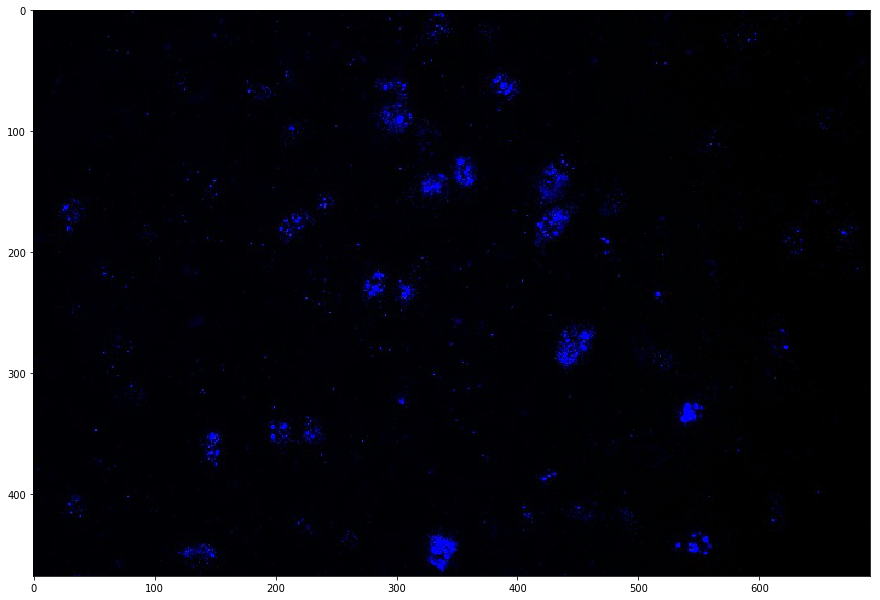

In [45]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

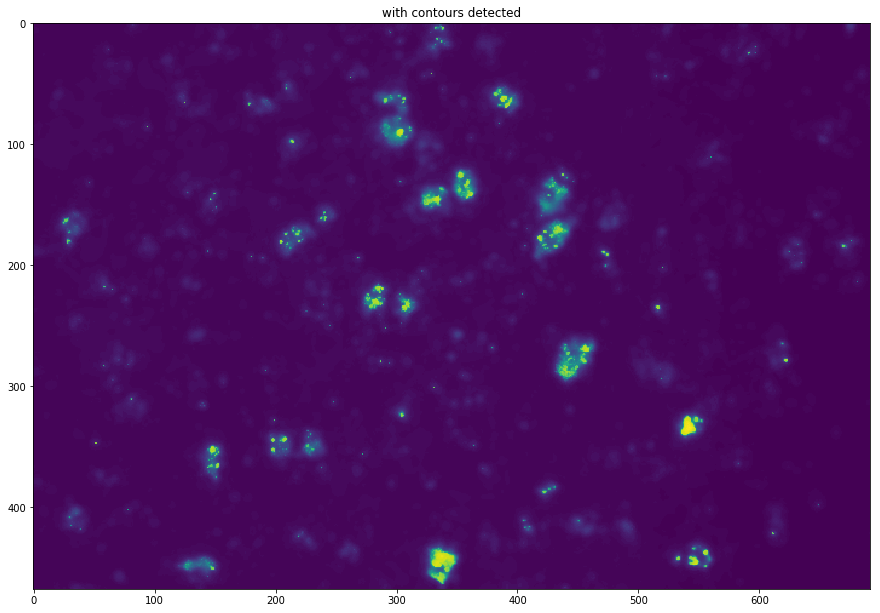

In [46]:
# blur
# blur = cv2.blur(image,(10,10))
blur = cv2.bilateralFilter(image ,9,75,75)

# convert to HSV
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.imshow(gray)
plt.title("with contours detected")

plt.show()

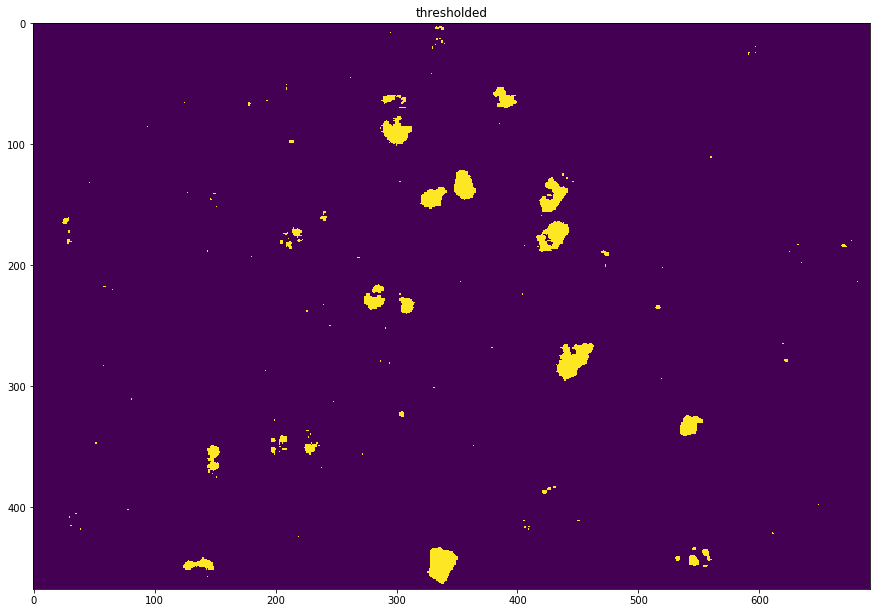

In [47]:
ret,thresh = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)

plt.figure(figsize=(15,15))
plt.title("thresholded")
plt.imshow(thresh)
plt.show()

28, 139


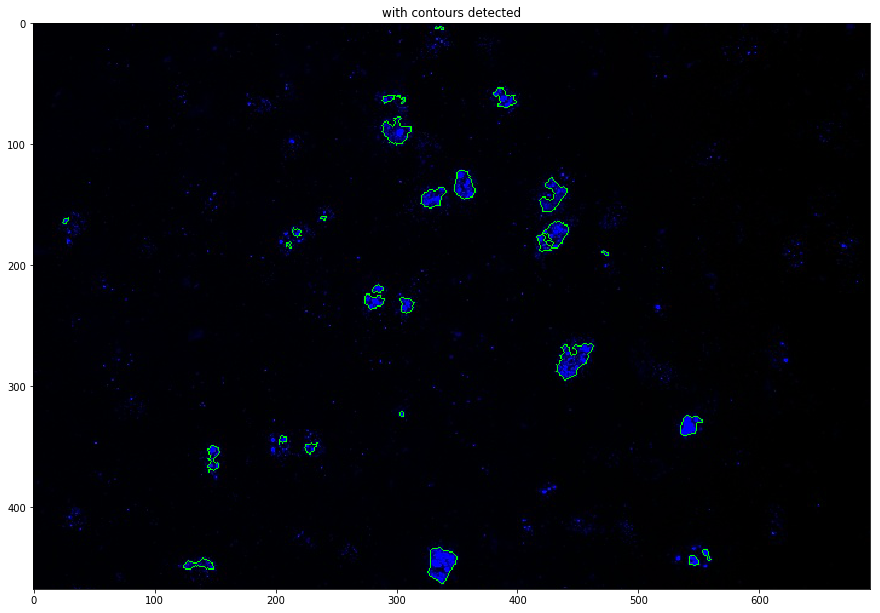

In [48]:
_, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# sizes = []
# for c in contours:
#     sizes.append(cv2.contourArea(c))
# print(sizes)

big_countours = [c for c in contours if cv2.contourArea(c) > 10]

print("{}, {}".format(len(big_countours), len(contours)))

cv2.drawContours(image, big_countours, -1, (0,255,0), 1)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.title("with contours detected")
plt.show()

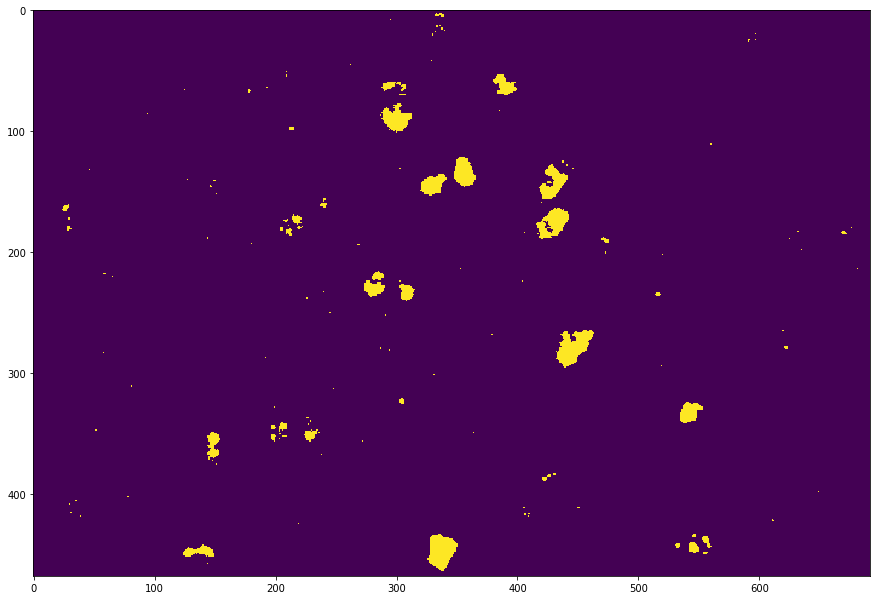

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [49]:
plt.figure(figsize=(15,15))
plt.imshow(thresh)
plt.show()

thresh[:5,:5]

## look at green image

28, 139


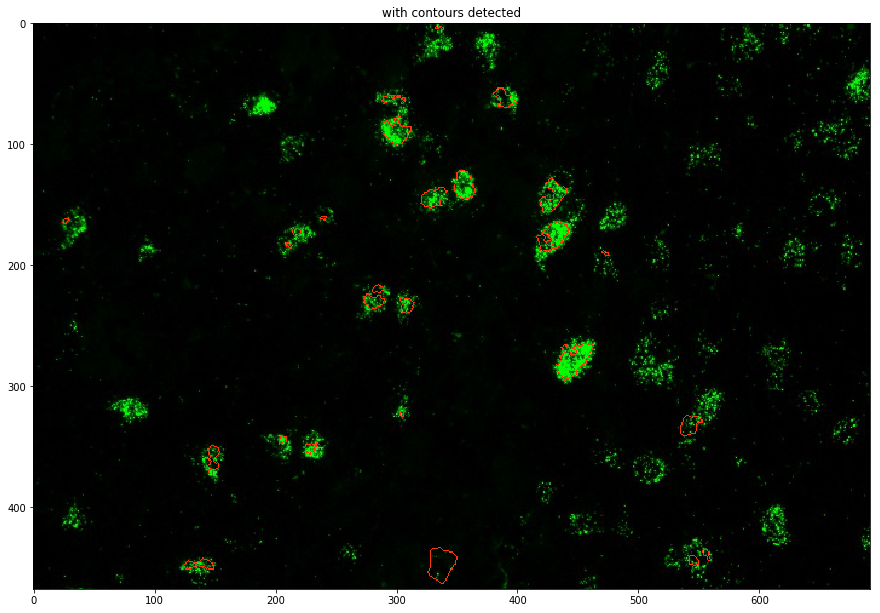

In [50]:
image = cv2.imread("test_green.jpg")

# crop to exlude scale bar
width, length, _ = image.shape
image = image[:int(width*0.9), :]

blur = cv2.bilateralFilter(image ,9,75,75)

gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

ret,thresh2 = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)

_, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# sizes = []
# for c in contours:
#     sizes.append(cv2.contourArea(c))
# print(sizes)

big_countours = [c for c in contours if cv2.contourArea(c) > 10]

print("{}, {}".format(len(big_countours), len(contours)))

cv2.drawContours(image, big_countours, -1, (255,54,10), 1)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.title("with contours detected")
plt.show()

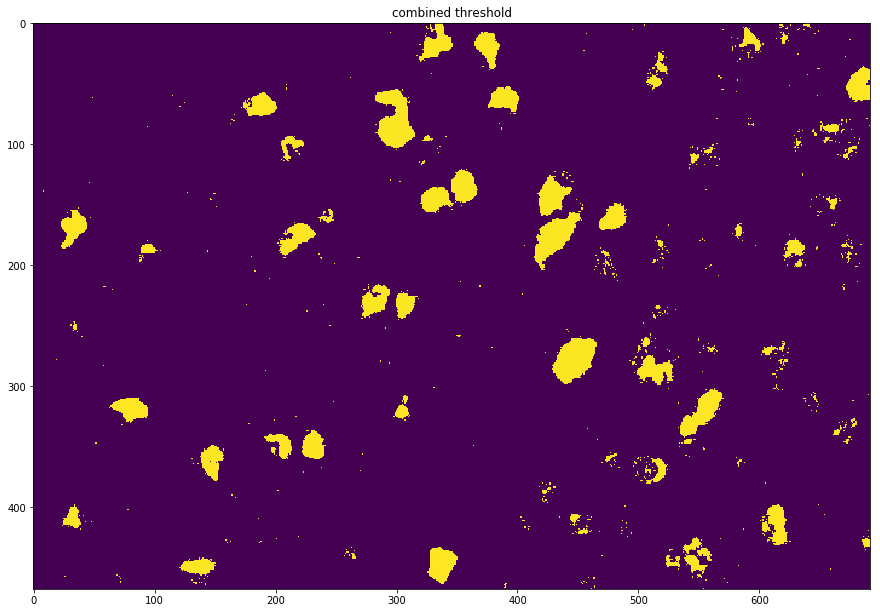

In [51]:
thresh_combined = thresh + thresh2

plt.figure(figsize=(15,15))
plt.imshow(thresh_combined)
plt.title("combined threshold")
plt.show()

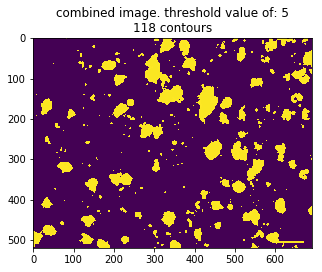

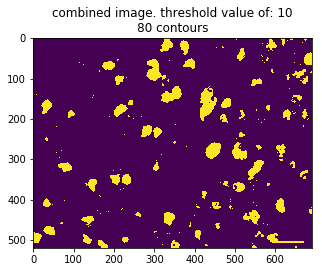

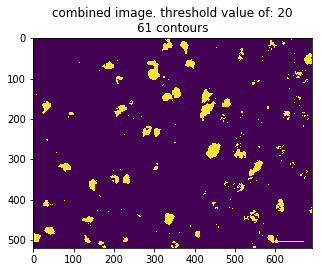

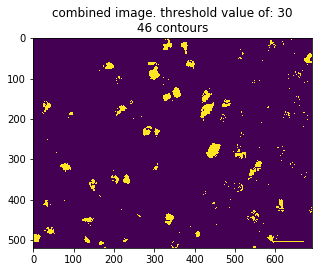

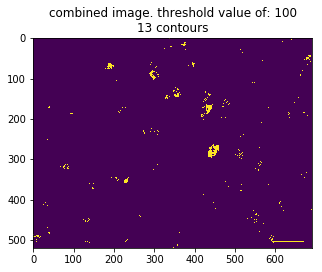

In [79]:
def threshold(x, threshold_parameter = 20):
    
    # crop to exlude scale bar
#     width, length, _ = x.shape
#     x = x[:int(width*0.9), :]

    blur = cv2.bilateralFilter(x, 9 ,75 ,75)

    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray,threshold_parameter,255,cv2.THRESH_BINARY)

#     big_countours = [c for c in contours if cv2.contourArea(c) > min_size]

#     cv2.drawContours(image, big_countours, -1, (255,54,10), 1)

    return thresh



thresholds = [5, 10, 20, 30, 100]

image1 = cv2.imread("test_green.jpg")
image2 = cv2.imread("test_red.jpg")

for thresh in thresholds:
    thresh1 = threshold(image1, threshold_parameter = thresh)
    thresh2 = threshold(image2, threshold_parameter = thresh)
    
    thresh_combined = thresh2 + thresh1
    
    _, contours, hierarchy = cv2.findContours(thresh_combined, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    big_countours = [c for c in contours if cv2.contourArea(c) > 20]    
    
    plt.figure(figsize = (5,5))
    plt.imshow(thresh_combined)
    plt.title("combined image. threshold value of: {}\n{} contours".format(thresh, len(big_countours)))
    plt.show()

Based on this, I'm going to use a threshold value of 10 when thresholding the photos. The combined image might make a nice map that we can layer onto each of the original photos.

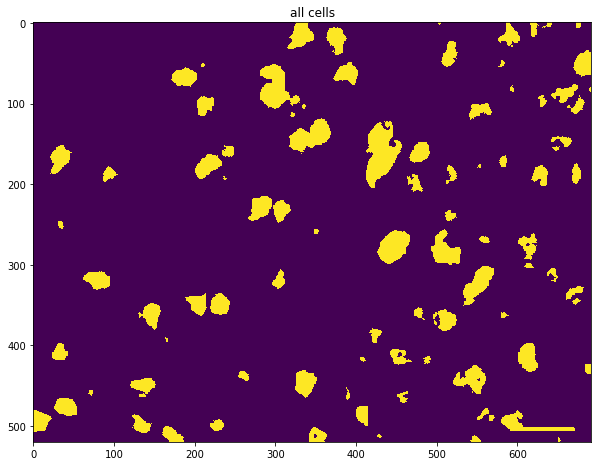

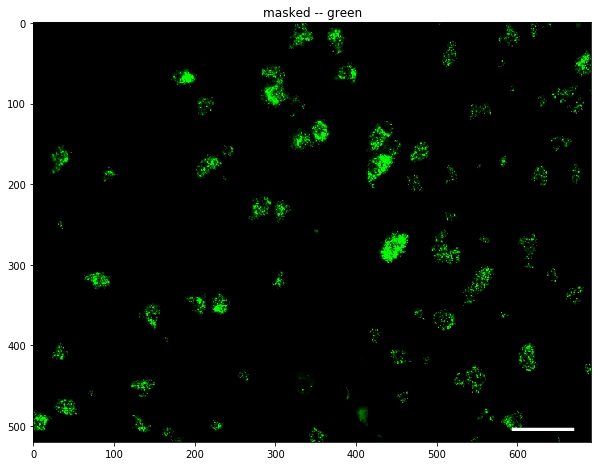

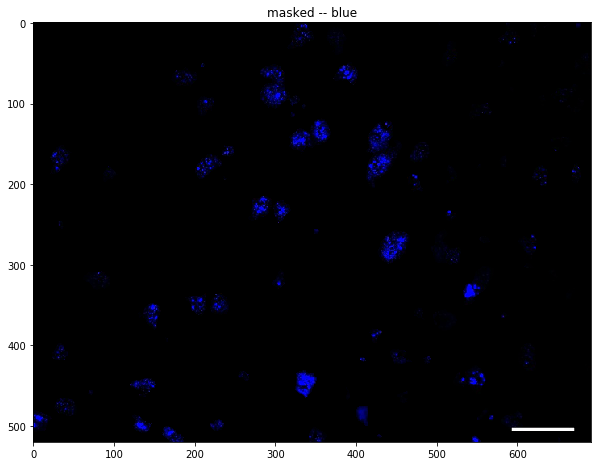

In [96]:
image1 = cv2.imread("test_green.jpg")
image2 = cv2.imread("test_red.jpg")

thresh1 = threshold(image1, threshold_parameter = 10)
thresh2 = threshold(image2, threshold_parameter = 10)

# combine
thresh_combined = thresh2 + thresh1

# get contours from the combined images to define cells
# create blank image
mask = np.zeros(thresh_combined.shape, np.uint8)
# get contours
_, contours, hierarchy = cv2.findContours(thresh_combined.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# exclude tiny contours
big_countours = [c for c in contours if cv2.contourArea(c) > 5]
# draw onto mask
cv2.drawContours(mask, big_countours, -1, (255), -1)

# mask = cv2.bitwise_not(thresh_combined)
res2 = cv2.bitwise_and(image2, image2, mask = mask)
res1 = cv2.bitwise_and(image1, image1, mask = mask)

plt.figure(figsize = (10,10))
plt.imshow(mask)
plt.title("all cells")
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(res1)
plt.title("masked -- green")
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(res2)
plt.title("masked -- blue")
plt.show()

In [115]:
# store list of contours from the combined image
## already in big contours


# apply to image 1
# for each contour, get the average intensity
image1_intensity = []
image2_intensity = []

for i in range(len(contours)):
    print(i)
    mask = np.zeros(image1.shape,np.uint8)
    mask = cv2.drawContours(mask, big_countours, i, color=255, thickness=-1)
    print(sum(mask))
    mean = cv2.mean(image1, mask = cimg)
    print(mean)
    # pick up here: http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html
#         pts = np.where(cimg == 255)
#         image1_intensity.append(image1[pts[0], pts[1]])
#         image2_intensity.append(image2[pts[0], pts[1]])
#     except:
#         print('nope')
#         image1_intensity.append('nope')
#         image2_intensity.append('nope')
    

# apply to image 2
# for each contour, get the average intensity

# categorize each cell

# cats = []
# for blue, green in zip(blue_list, green_list):
#     if blue >= 10 and green >= 10:
#         cats.append("coexpression")
#     elif blue > 10 and green < 10:
#         cats.append("blue_expression")
#     elif blue < 10 and green >= 10:
#         cats.append("green_expression")

0
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ..., 
 [0 0 0]
 [0 0 0]
 [0 0 0]]


error: /Users/travis/miniconda3/conda-bld/opencv_1495915512154/work/opencv-3.2.0/modules/core/src/stat.cpp:1472: error: (-215) mask.empty() || mask.type() == CV_8U in function mean


In [112]:
image2[pts[0]]

array([[[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ..., 
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ..., 
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[0, 0, 4],
        [0, 0, 4],
        [0, 0, 4],
        ..., 
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]], dtype=uint8)